In [2]:
import psutil
import multiprocessing
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# Purpose

This notebook is to test the performance of `psutil` for pulling system information for running processes (nodes). Specifically, we are interested in the following:

**What is the overhead of continuously instantiating `Process` objects vs. keeping a long-running instance.**

Experiment: 
To test re-instantiation:
1. Instantiate 100 new processes using the `multiprocessing` library.
2. For each process, create a new `psutil.Process` object and pull the process resources.
3. Measure the time it takes to pull the resources for all 100 processes 100 times.

To test long-running instance:
1. Instantiate 100 new processes using the `multiprocessing` library.
2. Create a single `psutil.Process` for each process.
3. Measure the time it takes to pull the resources for all 100 processes 100 times. 


**Is there a threshold for the number of processes that can be monitored before the overhead becomes too great?**


In [3]:
# Process function to be run
def process_func():
    import time
    while True:
        time.sleep(1)

# Create N processes
def create_procs(N, exe=process_func):
    procs = []
    for i in range(N):
        # Create the process, making sure to disable stdout
        p = multiprocessing.Process(target=exe)
        p.start()
        procs.append(p)
    return procs

# Stop all processes
def stop_procs(procs):
    for p in procs:
        p.terminate()

# Loop over the processes and create a new psutil.Process for each
def get_resources(procs, M=100):
    for i in range(M):
        for p in procs:
                process = psutil.Process(p.pid)
                with process.oneshot():
                    resources = process.status(), process.cpu_percent(), process.memory_percent(), process.num_threads(), process.num_fds()

In [4]:
# Test re-instantiation
procs = create_procs(100)
%timeit get_resources(procs, 1)

6.18 ms ± 346 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
stop_procs(procs)

In [6]:
# Test long-running instance
def get_resources_batched(procs, processes, M=100):
    for i in range(M):
        for p in procs:
            with processes[p.pid].oneshot():
                resources = processes[p.pid].status(), processes[p.pid].cpu_percent(), processes[p.pid].memory_percent(), processes[p.pid].num_threads(), processes[p.pid].num_fds()

In [7]:
procs = create_procs(100)
processes = {p.pid: psutil.Process(p.pid) for p in procs}

%timeit get_resources_batched(procs, processes, 1)

10.3 ms ± 743 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
stop_procs(procs)

# Parametric Study

Let's test the overhead of both methods for different numbers of processes a number of times.

In [9]:
import pandas as pd
import time

In [10]:
N_PROCS_RANGE = range(10, 200, 10) # Number of processes
M_ITER_RANGE = [100]

In [11]:
def test_reinstantiation(N, M):
    procs = create_procs(N)
    start = time.time()
    get_resources(procs, M)
    end = time.time()
    stop_procs(procs)
    return end - start

def test_long_running_instance(N, M):
    procs = create_procs(N)
    processes = {p.pid: psutil.Process(p.pid) for p in procs}
    start = time.time()
    get_resources_batched(procs, processes, M)
    end = time.time()
    stop_procs(procs)
    return end - start

def run_tests(N_RANGE, M_RANGE):
    results = []
    for N in N_RANGE:
        for M in M_RANGE:
            # Run it 10 times and take the average
            intermediate_results = []
            for i in range(10):
                intermediate_results.append({'N': N, 'M': M, 'reinstantiation': test_reinstantiation(N, M), 'long_running_instance': test_long_running_instance(N, M)})
            results.append(pd.DataFrame(intermediate_results).mean().to_dict())    
    return pd.DataFrame(results)

In [12]:
results = run_tests(N_PROCS_RANGE, M_ITER_RANGE)

In [16]:
results

,N,M,reinstantiation,long_running_instance,reinstantiation_overhead
0,10.0,100.0,0.072680,0.065390,0.007290
1,20.0,100.0,0.149257,0.148077,0.001180
2,30.0,100.0,0.249820,0.221057,0.028762
3,40.0,100.0,0.317811,0.338362,-0.020551
4,50.0,100.0,0.676534,0.495312,0.181223
5,60.0,100.0,0.937216,0.776596,0.160620
6,70.0,100.0,0.934690,0.859750,0.074940
7,80.0,100.0,0.994732,1.129173,-0.134441
8,90.0,100.0,1.255535,1.147024,0.108511
9,100.0,100.0,1.476668,1.433379,0.043289


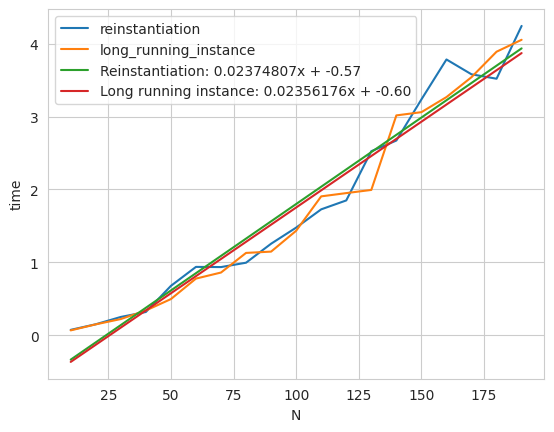

In [17]:
# Plot the results
results_long = results.melt(id_vars=['N', 'M'], value_vars=['reinstantiation', 'long_running_instance'], var_name='method', value_name='time')
sns.lineplot(data=results_long, x='N', y='time', hue='method')

# Fit a line to both methods, add a label, show the slope and intercept
from scipy.optimize import curve_fit
def func(x, a, b):
    return a * x + b

opt_reinstantiation, _ = curve_fit(func, results.N, results.reinstantiation)
opt_long_running_instance, _ = curve_fit(func, results.N, results.long_running_instance)
plt.plot(results.N, func(results.N, *opt_reinstantiation), label=f"Reinstantiation: {opt_reinstantiation[0]:.8f}x + {opt_reinstantiation[1]:.2f}")
plt.plot(results.N, func(results.N, *opt_long_running_instance), label=f"Long running instance: {opt_long_running_instance[0]:.8f}x + {opt_long_running_instance[1]:.2f}")
plt.legend()

plt.show()

In [15]:
# Calculate how much extra time is used by the reinstantiation method as a function of N
results['reinstantiation_overhead'] = results.reinstantiation - results.long_running_instance

# Aggregate the results
results_agg = results.groupby('N').agg({'reinstantiation': 'mean', 'long_running_instance': 'mean', 'reinstantiation_overhead': 'mean'})
results_agg

,reinstantiation,long_running_instance,reinstantiation_overhead
N,,,
10.0,0.072680,0.065390,0.007290
20.0,0.149257,0.148077,0.001180
30.0,0.249820,0.221057,0.028762
40.0,0.317811,0.338362,-0.020551
50.0,0.676534,0.495312,0.181223
60.0,0.937216,0.776596,0.160620
70.0,0.934690,0.859750,0.074940
80.0,0.994732,1.129173,-0.134441
90.0,1.255535,1.147024,0.108511


# Conclusion

The difference between the two methods is negligible. The overhead of re-instantiating `psutil.Process` objects is not significantly different from keeping a long-running instance. The overhead is linear with the number of processes being monitored.